# Recommender System for Board Games from [BoardGameGeek.com](https://boardgamegeek.com/)



1.   Iatrou Manos
2.   Papageorgiou Vasileios
3. Sykianakis Xaralambos




# Dataset Description



*   Games File
*   User Ratings File
*   Mechanics File
*   Themes File



In [1]:
#!pip install tomotopy
import pandas as pd
import numpy as np
import os
import glob
from pathlib import Path
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
folder_path = Path('/content/drive/MyDrive/Colab Notebooks/Advanced Customer Analytics/Interpretable Predictions/Recommender_Files')

In [4]:
def get_description(df):
    def categorize(row):
        categories = []
        for col in df.columns[15:]:
            if row[col] > 0:
                category = col
                categories.append(category)
        return ','.join(categories) if categories else 'Other'
    return df.apply(categorize,axis=1)

In [5]:
def downcasting_types(df: pd.DataFrame):
  for column in df.columns:
    colType = df[column].dtype
    if colType == 'float64' :
      df[column] = pd.to_numeric(df[column], downcast='float')
    elif colType == 'int64' :
      df[column] = pd.to_numeric(df[column], downcast='integer')
  return df

In [6]:
def preprocess(df, file_name):
    """
    Args:
    df (DataFrame): The DataFrame to be preprocessed.
    file_name (str): The name of the file corresponding to the DataFrame.

    Returns:
    DataFrame: The preprocessed DataFrame.
    """

    if file_name == "games":
        columns_to_keep = ['BGGId','Name','GameWeight','MfgPlaytime','NumAlternates','NumExpansions','NumImplementations','Kickstarted',
                   'Cat:Thematic','Cat:Strategy','Cat:War','Cat:Family','Cat:CGS','Cat:Abstract','Cat:Party','Cat:Childrens']
        df = df[columns_to_keep].copy()
        renaming_dict = {col: col.replace('Cat:', '') if col.startswith('Cat:')
                 else col
                 for col in df.columns}
        df.rename(columns=renaming_dict,inplace=True)
    elif file_name == "themes":
        renaming_dict = {col: col.replace('Theme_', '') if col.startswith('Theme_')
                 else col
                 for col in df.columns}
        df.rename(columns=renaming_dict,inplace=True)
    elif file_name == "mechanics":
        pass
    elif file_name == "user_ratings":
        df['Rating'] = df['Rating'].apply(lambda x: 1 if x>6 else 0)
        label_encoder = LabelEncoder()
        df['uid'] = label_encoder.fit_transform(df['Username'])
        #df.drop('Username',axis=1,inplace=True)
        df = df.groupby(['uid','Username']).filter(lambda x: len(x) >= 300).groupby('BGGId').filter(lambda x: len(x) >= 100)

    return df

In [7]:
def load_train(path: str):
    """
    Load all CSV files in the path folder, preprocess them, and merge certain DataFrames.

    Args:
    path (str): The path to the folder containing CSV files.

    Returns:
    DataFrame: A single merged DataFrame of the preprocessed files.
    """
    folder = Path(path)
    if not folder.exists() or not folder.is_dir():
        raise FileNotFoundError(f"{path} directory was not found")

    dataframes = {}
    for file in folder.glob('*.csv'):
        file_name = file.stem
        df = pd.read_csv(file)

        if file_name in ['games', 'themes', 'mechanics', 'user_ratings']:
            df = preprocess(df, file_name)
        else:
            print(f"Warning: No preprocessing defined for file '{file_name}'. Loaded without preprocessing.")

        dataframes[file_name] = df

    # Merging the DataFrames
    # Adjust the following lines according to your actual key columns and required types of joins
    merged_df = pd.merge(dataframes['games'], dataframes['mechanics'], on='BGGId', how='left')
    games_df = pd.merge(merged_df, dataframes['themes'], on='BGGId', how='left')
    games_df['Details'] = get_description(games_df)

    #columns_to_drop = dataframes['themes'].columns.tolist() + dataframes['mechanics'].columns.tolist()
    columns_to_drop = [col for col in dataframes['themes'].columns.tolist() + dataframes['mechanics'].columns.tolist() if col != 'BGGId']
    games_df = games_df.drop(columns=columns_to_drop,axis=1)
    user_ratings_df = dataframes.get('user_ratings', None)
    user_ratings_df = downcasting_types(user_ratings_df)
    games_df = downcasting_types(games_df)

    return user_ratings_df, games_df

In [8]:
user_ratings_df, games_df = load_train(folder_path)

## Extra Code (to be removed)

In [9]:
#csv_files = list(folder_path.glob('*.csv'))

In [10]:
#dataframes = {}
#for file in csv_files:
#    filename = file.stem
#    dataframes[filename] = pd.read_csv(file)

In [11]:
#print(dataframes.keys())

In [12]:
#dataframes["games"].columns

In [13]:
# Keep only relevant columns

#columns_to_keep = ['BGGId', 'Name','YearPublished', 'GameWeight', 'LanguageEase',
#                   'MfgPlaytime', 'MfgAgeRec', 'NumAlternates', 'NumExpansions',
#                   'NumImplementations', 'Kickstarted', 'Cat:Thematic',
#                   'Cat:Strategy', 'Cat:War', 'Cat:Family', 'Cat:CGS',
#                   'Cat:Abstract', 'Cat:Party', 'Cat:Childrens']

In [14]:
#df = dataframes['games'].loc[:,columns_to_keep]

#games_df = df[(df['YearPublished'] > 1960) & (df['GameWeight'] > 0)]

## Continue Here

In [15]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21925 entries, 0 to 21924
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BGGId               21925 non-null  int32  
 1   Name                21925 non-null  object 
 2   GameWeight          21925 non-null  float32
 3   MfgPlaytime         21925 non-null  int32  
 4   NumAlternates       21925 non-null  int16  
 5   NumExpansions       21925 non-null  int16  
 6   NumImplementations  21925 non-null  int8   
 7   Kickstarted         21925 non-null  int8   
 8   Thematic            21925 non-null  int8   
 9   Strategy            21925 non-null  int8   
 10  War                 21925 non-null  int8   
 11  Family              21925 non-null  int8   
 12  CGS                 21925 non-null  int8   
 13  Abstract            21925 non-null  int8   
 14  Party               21925 non-null  int8   
 15  Childrens           21925 non-null  int8   
 16  Deta

In [16]:
games_df.describe()

,BGGId,GameWeight,MfgPlaytime,NumAlternates,NumExpansions,NumImplementations,Kickstarted,Thematic,Strategy,War,Family,CGS,Abstract,Party,Childrens
count,21925.000000,21925.000000,21925.000000,21925.000000,21925.000000,21925.000000,21925.000000,21925.000000,21925.00000,21925.000000,21925.000000,21925.000000,21925.000000,21925.000000,21925.000000
mean,117652.663216,1.982131,90.513523,1.603786,1.380068,0.308734,0.153341,0.055827,0.10577,0.161003,0.105633,0.013820,0.050855,0.029190,0.040182
std,104628.721777,0.848983,529.657389,9.619364,7.701036,0.848095,0.360324,0.229592,0.30755,0.367542,0.307374,0.116745,0.219707,0.168344,0.196391
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12346.000000,1.333300,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,105305.000000,1.968800,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,206169.000000,2.525200,90.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,349161.000000,5.000000,60000.000000,850.000000,525.000000,38.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
user_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5277493 entries, 167 to 18942047
Data columns (total 4 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   BGGId     int32 
 1   Rating    int8  
 2   Username  object
 3   uid       int32 
dtypes: int32(2), int8(1), object(1)
memory usage: 125.8+ MB


In [18]:
user_ratings_df.describe()

,BGGId,Rating,uid
count,5.277493e+06,5.277493e+06,5.277493e+06
mean,1.066875e+05,6.486874e-01,2.196058e+05
std,9.211239e+04,4.773805e-01,1.179645e+05
min,1.000000e+00,0.000000e+00,6.000000e+00
25%,1.581800e+04,0.000000e+00,1.189370e+05
50%,1.004230e+05,1.000000e+00,2.315960e+05
75%,1.789000e+05,1.000000e+00,3.201930e+05
max,3.469650e+05,1.000000e+00,4.113600e+05


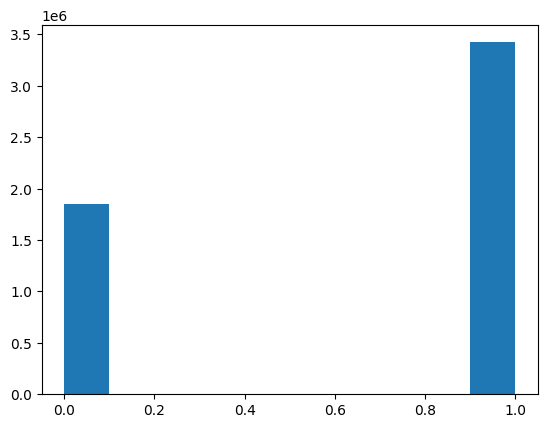

In [19]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.hist(user_ratings_df['Rating']);

In [99]:
# Remove positive results
positive_rows = user_ratings_df[user_ratings_df['Rating'] == 1]
rows_to_remove = positive_rows.sample(frac=0.5, random_state=42)
user_ratings_df = user_ratings_df.drop(rows_to_remove.index)

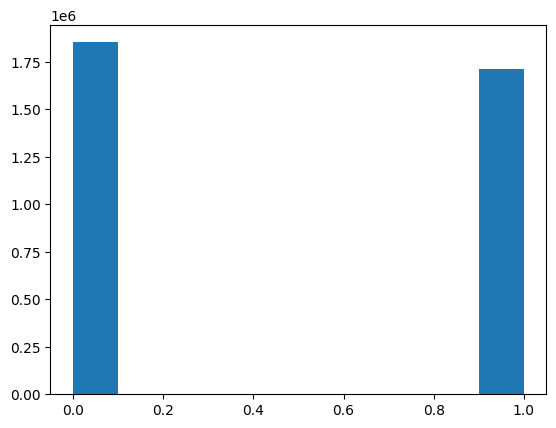

In [100]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.hist(user_ratings_df['Rating']);

In [101]:
# Function to find easily the name of the BoardGame
board_game_mapper = defaultdict()
for i, name in zip(games_df['BGGId'], games_df['Name']):
    board_game_mapper[str(i)] = name

# Function to find easily the username
users_mapper = defaultdict()
for i, name in zip(user_ratings_df['uid'], user_ratings_df['Username']):
  users_mapper[str(i)] = name

In [102]:
user_ratings_df.head()

,BGGId,Rating,Username,uid
167,1252,0,Handballer,78240
168,1252,0,Mobby,128664
171,1252,0,kathuna,307302
174,1252,0,Joe Casadonte,93850
178,1252,0,j-berman,293389


In [103]:
print(board_game_mapper['271'])
print(users_mapper['78240'])

It's Mine!
Handballer


# Ranking task of Recommender System

In [23]:
!pip install -q tensorflow-recommenders

In [24]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs

## Prepare Datasets - Keep only relevant columns

In [104]:
# Games -- DataFrame2Tensor

# Create a dict of the features we want to keep first
games_dict = {'game_id': games_df['BGGId'].astype(str),
              'game_name':games_df['Name'].astype(str),
              'complexity': games_df['GameWeight'].astype(np.float32)}

game_tf = tf.data.Dataset.from_tensor_slices(games_dict)

# Ratings -- DataFrame2

#ratings['Rating'] = ratings['Rating'].apply(lambda x: 1 if x > 7 else 0)

ratings_dict ={'game_id':user_ratings_df['BGGId'].astype(str),
               'user_id':user_ratings_df['uid'].astype(str),
               'rating':user_ratings_df['Rating'].astype(np.int8)}

ratings_tf = tf.data.Dataset.from_tensor_slices(ratings_dict)

In [105]:
for game in game_tf.take(5):
  print(game)

{'game_id': <tf.Tensor: shape=(), dtype=string, numpy=b'1'>, 'game_name': <tf.Tensor: shape=(), dtype=string, numpy=b'Die Macher'>, 'complexity': <tf.Tensor: shape=(), dtype=float32, numpy=4.3206>}
{'game_id': <tf.Tensor: shape=(), dtype=string, numpy=b'2'>, 'game_name': <tf.Tensor: shape=(), dtype=string, numpy=b'Dragonmaster'>, 'complexity': <tf.Tensor: shape=(), dtype=float32, numpy=1.963>}
{'game_id': <tf.Tensor: shape=(), dtype=string, numpy=b'3'>, 'game_name': <tf.Tensor: shape=(), dtype=string, numpy=b'Samurai'>, 'complexity': <tf.Tensor: shape=(), dtype=float32, numpy=2.4859>}
{'game_id': <tf.Tensor: shape=(), dtype=string, numpy=b'4'>, 'game_name': <tf.Tensor: shape=(), dtype=string, numpy=b'Tal der K\xc3\xb6nige'>, 'complexity': <tf.Tensor: shape=(), dtype=float32, numpy=2.6667>}
{'game_id': <tf.Tensor: shape=(), dtype=string, numpy=b'5'>, 'game_name': <tf.Tensor: shape=(), dtype=string, numpy=b'Acquire'>, 'complexity': <tf.Tensor: shape=(), dtype=float32, numpy=2.5031>}


In [106]:
for rating in ratings_tf.take(5):
  print(rating)

{'game_id': <tf.Tensor: shape=(), dtype=string, numpy=b'1252'>, 'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'78240'>, 'rating': <tf.Tensor: shape=(), dtype=int8, numpy=0>}
{'game_id': <tf.Tensor: shape=(), dtype=string, numpy=b'1252'>, 'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'128664'>, 'rating': <tf.Tensor: shape=(), dtype=int8, numpy=0>}
{'game_id': <tf.Tensor: shape=(), dtype=string, numpy=b'1252'>, 'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'307302'>, 'rating': <tf.Tensor: shape=(), dtype=int8, numpy=0>}
{'game_id': <tf.Tensor: shape=(), dtype=string, numpy=b'1252'>, 'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'93850'>, 'rating': <tf.Tensor: shape=(), dtype=int8, numpy=0>}
{'game_id': <tf.Tensor: shape=(), dtype=string, numpy=b'1252'>, 'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'293389'>, 'rating': <tf.Tensor: shape=(), dtype=int8, numpy=0>}


## Create the ranking model

In [107]:
# Find unique users and games

game_ids = game_tf.batch(1_000_000).map(lambda x: x["game_id"])
user_ids = ratings_tf.batch(1_000_000).map(lambda x: x["user_id"])

unique_games = np.unique(np.concatenate(list(game_ids)))
unique_users = np.unique(np.concatenate(list(user_ids)))

print("unique_games:", len(unique_games))
print("unique_users:", len(unique_users))

unique_games: 21925
unique_users: 10778


In [29]:
# # Query - User model

# class UserModel(tf.keras.Model):

#   def __init__(self, embedding_dimension):
#     super().__init__()

#     self.embedding_dimension = embedding_dimension

#     self.user_embedding = tf.keras.Sequential([
#         tf.keras.layers.StringLookup(
#             vocabulary=unique_users, mask_token=None),
#         tf.keras.layers.Embedding(len(unique_users) + 1, self.embedding_dimension),
#     ])

#   def call(self, inputs):
#       return self.user_embedding(inputs["user_id"])

# # Candidate - Game Model

# class GameModel(tf.keras.Model):
#   def __init__(self, embedding_dimension):
#       super().__init__()

#       self.embedding_dimension = embedding_dimension

#       self.game_embedding = tf.keras.Sequential([
#         tf.keras.layers.StringLookup(
#             vocabulary=unique_games, mask_token=None),
#         tf.keras.layers.Embedding(len(unique_games) + 1, self.embedding_dimension)
#       ])

#   def call(self, inputs):
#     return self.game_embedding(inputs["game_id"])

In [108]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(vocabulary=unique_users, mask_token=None),
      tf.keras.layers.Embedding(len(unique_users)+1, embedding_dimension)
    ])

    # Compute embeddings for games.
    self.game_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(vocabulary=unique_games, mask_token=None),
      tf.keras.layers.Embedding(len(unique_games) + 1, embedding_dimension)
    ])

    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(254, activation="relu"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(128, activation="relu"),
      tf.keras.layers.BatchNormalization(),
      # Make rating predictions in the final layer.
      #tf.keras.layers.Dense(1)
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  def call(self, inputs):

    user_id, game_id = inputs

    user_embedding = self.user_embeddings(user_id)
    game_embedding = self.game_embeddings(game_id)

    return self.ratings(tf.concat([user_embedding, game_embedding], axis=1))

In [109]:
class GameModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task : tf.keras.layers.Layer = tfrs.tasks.Ranking(
      #loss=tf.keras.losses.MeanSquaredError(),
      #metrics=[tf.keras.metrics.RootMeanSquaredError()
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.BinaryAccuracy()]
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["user_id"], features["game_id"]))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    labels = features.pop("rating")

    rating_predictions = self(features)

        # Calculate class weights based on class distribution
    class_weights = {
        0: 1.5,
        1: 1.0
    }

    #binary_predictions=tf.where(rating_predictions > 0.5,1,0)

    # The task computes the loss and the metrics.
    #return self.task(labels=tf.cast(labels,tf.int8), predictions = tf.cast(binary_predictions,tf.int8) )

    return self.task(labels=labels,predictions = rating_predictions)

    # # Manually apply class weights to BinaryCrossentropy loss

    # # Cast class weights to float32
    # class_weights = {key: tf.constant(value, dtype=tf.float32) for key, value in class_weights.items()}

    # # Cast labels to float32
    # labels = tf.cast(labels, dtype=tf.float32)

    # # Calculate raw BinaryCrossentropy loss
    # raw_loss = tf.keras.losses.BinaryCrossentropy()(labels, rating_predictions)

    # # Manually apply class weights to the loss
    # weighted_loss = labels * class_weights[1] * raw_loss + (1 - labels) * class_weights[0] * raw_loss

    # # Take the mean of the weighted loss
    # loss = tf.reduce_mean(weighted_loss)

    # # Compute metric
    # binary_accuracy = tf.keras.metrics.BinaryAccuracy()
    # binary_accuracy.update_state(labels, rating_predictions)
    # metric_value = binary_accuracy.result()

    # return loss, metric_value

In [110]:
model = GameModel()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

In [111]:
tf.random.set_seed(42)
shuffled = ratings_tf.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [80]:
# # Assuming cached_train is a tuple or list containing features and labels
# X_train, y_train = cached_train

# # Print or inspect the shapes of X_train and y_train
# print("X_train shape:", X_train.shape)
# print("y_train shape:", y_train.shape)

# # Check for any missing values in y_train
# print("Missing values in y_train:", y_train.isnull().sum())

In [112]:
model.fit(cached_train, epochs=10)

Epoch 1/10
10/10 [==============================] - 5s 107ms/step - binary_accuracy: 0.6425 - loss: 0.6182 - regularization_loss: 0.0000e+00 - total_loss: 0.6182
Epoch 2/10
10/10 [==============================] - 1s 92ms/step - binary_accuracy: 0.7508 - loss: 0.4814 - regularization_loss: 0.0000e+00 - total_loss: 0.4814
Epoch 3/10
10/10 [==============================] - 1s 88ms/step - binary_accuracy: 0.8028 - loss: 0.4138 - regularization_loss: 0.0000e+00 - total_loss: 0.4138
Epoch 4/10
10/10 [==============================] - 1s 87ms/step - binary_accuracy: 0.8243 - loss: 0.3780 - regularization_loss: 0.0000e+00 - total_loss: 0.3780
Epoch 5/10
10/10 [==============================] - 1s 91ms/step - binary_accuracy: 0.8368 - loss: 0.3462 - regularization_loss: 0.0000e+00 - total_loss: 0.3462
Epoch 6/10
10/10 [==============================] - 1s 91ms/step - binary_accuracy: 0.8411 - loss: 0.3255 - regularization_loss: 0.0000e+00 - total_loss: 0.3255
Epoch 7/10
10/10 [===============

In [113]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 1s 89ms/step - binary_accuracy: 0.7482 - loss: 1.1785 - regularization_loss: 0.0000e+00 - total_loss: 1.1785


{'binary_accuracy': 0.748199999332428,
 'loss': 1.254885196685791,
 'regularization_loss': 0,
 'total_loss': 1.254885196685791}

In [116]:
test_ratings = {}
test_game_ids = ["218576", "132188", "272","118553","374"]
for test_game in test_game_ids:
  test_ratings[test_game] = model({
      "user_id": np.array(["10341"]),
      "game_id": np.array([test_game])
  })

print(f"Ratings: for user {users_mapper['10341']}")
for id, score in test_ratings.items():
  print(f"{board_game_mapper[id]},'{id}': {score}")

Ratings: for user AnttiT
Fantastic Park,'218576': [[0.14369911]]
Spin Monkeys,'132188': [[0.9482664]]
Downtown,'272': [[0.9936123]]
Ubongo Trigo,'118553': [[0.9887548]]
Colorado County,'374': [[0.62566084]]


In [115]:
user_ratings_df[user_ratings_df['uid']==10341].head()

,BGGId,Rating,Username,uid
18256,218576,0,AnttiT,10341
22599,132188,0,AnttiT,10341
23050,272,0,AnttiT,10341
80480,118553,1,AnttiT,10341
115926,374,1,AnttiT,10341


In [39]:
test_ratings.items()

dict_items([('36218', <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.52710396]], dtype=float32)>), ('15721', <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.80650866]], dtype=float32)>), ('9802', <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.7797532]], dtype=float32)>), ('235511', <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.6000359]], dtype=float32)>), ('118553', <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49949062]], dtype=float32)>)])

In [40]:
model({"user_id": np.array(["125874"]), "game_id": np.array(["249552"])})

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5410684]], dtype=float32)>

In [41]:
user_ratings_df.head()

,BGGId,Rating,Username,uid
167,1252,0,Handballer,78240
168,1252,0,Mobby,128664
171,1252,0,kathuna,307302
174,1252,0,Joe Casadonte,93850
178,1252,0,j-berman,293389


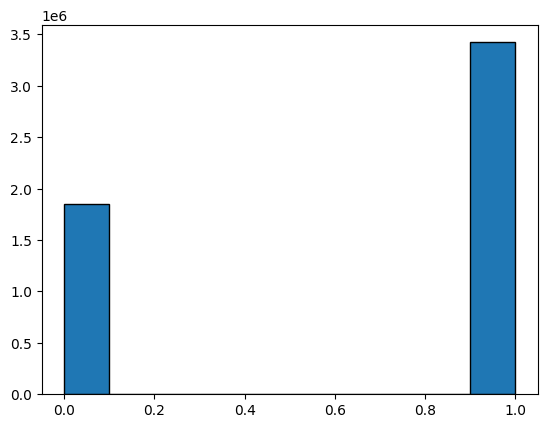

In [95]:
# Plotting the histogram
plt.hist(user_ratings_df['Rating'], bins=10, edgecolor='black');

#plt.hist(ratings[ratings.BGGId==218489].Rating , bins=10, edgecolor='black');